# Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection

## Text Classification Architecture

- Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

- smam classification, sentiment classification, toxic comment, emotion classification etc.


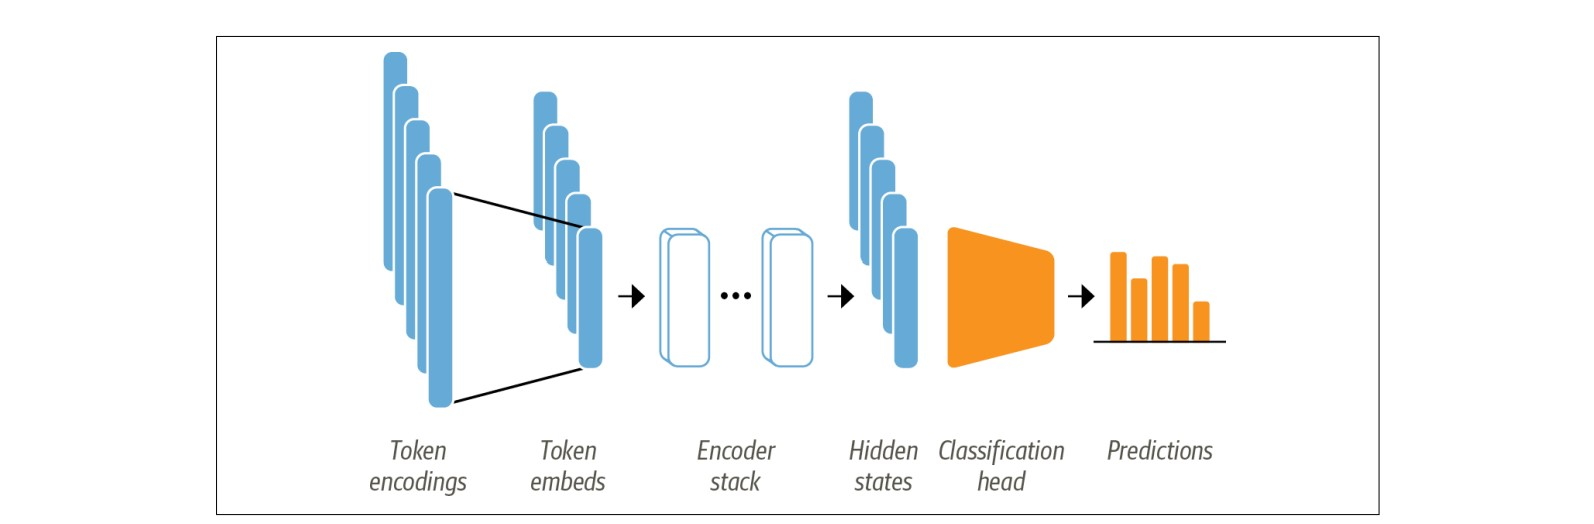

## Importing Libraries

In [2]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from transformers import pipeline

import torch
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import numpy as np
import time

# Don't do in production. Doing now to keep output clean for understanding
import warnings     # this is for:  ignore all warning messages
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.isnull().sum()   # Very missing values
df = df.dropna()        # Drop missing values
df.isnull().sum()       # Verify again

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [5]:
df['label'].value_counts()   # Very imbalanced dataset

label
0    10361
1     7920
Name: count, dtype: int64

## Dataset Analysis

I want to see the distribution of the classes in the dataset. Distribution means how many samples are there for each class. This is important because if the dataset is imbalanced, then the model will be biased towards the majority class. In this case, the model will be biased towards the "Real" class.

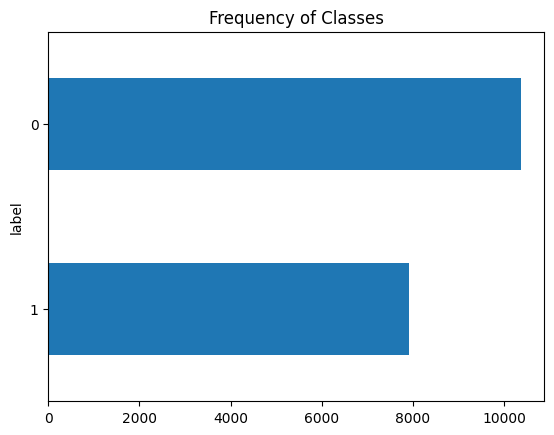

In [6]:
label_counts = df['label'].value_counts(ascending=True)     # select the column, then count the values, then sort the values

label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

I want to see the distribution of the text length in the dataset. This is important because the model will be trained on the text data. If the text length is too long, then the model will take more time to train. If the text length is too short, then the model will not be able to learn the patterns in the text data.

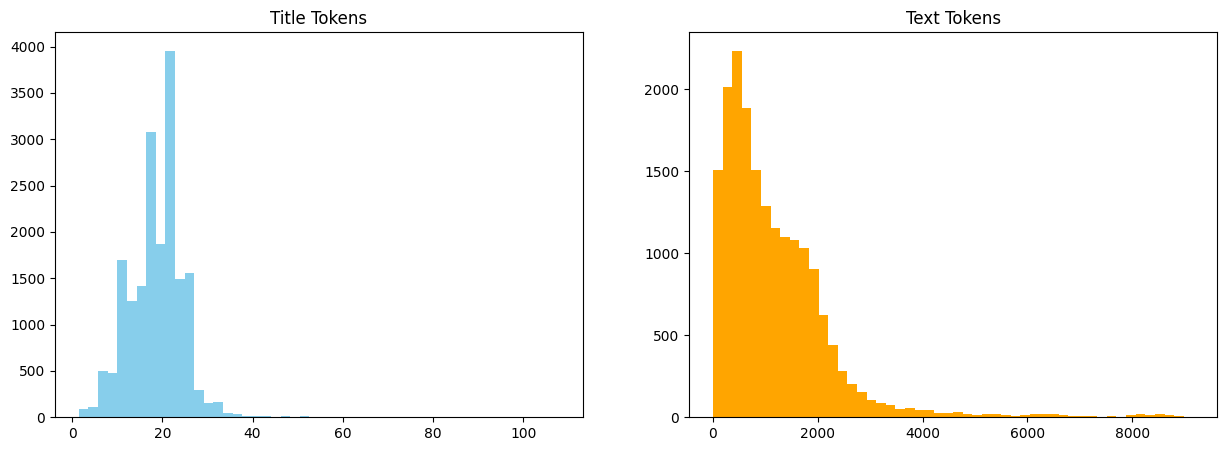

In [7]:
# Models BERT use subwords tokenization. When the model see a new word, it will break it down into subwords. 
# -> autoencoder == auto + encoder
# 1.5 tokens per word on average is a good rule of thumb for BERT models

df['title_tokens'] = df['title'].apply(lambda x: len(       # x is any row in the column
    x.split()   # split the text into words
)*1.5   # any word will be broken down into 1.5 tokens
                                       )
df['text_tokens'] = df['text'].apply(lambda x: len(
    x.split()
)*1.5
                                     )

# subplots is a funct that we can create multiple plots in the same figure
fig, ax = plt.subplots(     # fig is the obj figure, ax is the axes -> ax[0] is the first plot, ax[1] is the second plot <-
    1, 2,   # 1 row, 2 columns
    figsize=(15,5)   # size of the figure
)

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

## Data Loader and Train Test Split

In [8]:
# 70% for training, 20% test, 10% validation
# 10% is for validation because we want to tune the hyperparameters of the model

train, test = train_test_split(df, 
                               test_size=0.3, 
                               stratify=df['label'])     # param: stratify -> keep the same distribution of classes in the train and test set

test, validation = train_test_split(test, test_size=1/3,   # 1/3 of the test set will be the validation set
                                    stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape

((12796, 7), (3656, 7), (1829, 7), (18281, 7))

- I use the Hugging Face Dataset library to create a dataset object. This object will be used to tokenize the text data. Tokenization is the process of converting text data into numerical data. The model will be trained on numerical data. The dataset object will also be used to create the data loader. The data loader will be used to load the data in batches. The model will be trained on batches of data.

- In traditional machine learning models, it is common to work with arrays or lists. These are simpler and may be good enough for many tasks. However, when working with NLP and advanced libraries like Hugging Face, DatasetDict offers additional advantages in terms of structure, manipulation and integration of advanced functionality.

In [9]:
dataset = DatasetDict(     # For model's hugging face is better to use DatasetDict
    {
        "train": Dataset.from_pandas(train, preserve_index=False),      # preserve_index=False -> don't keep the index of the row
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## Data Tokenization

In [10]:
text = "Machine learning is awesome!!"

# Use the AutoTokenizer class to load the tokenizer for the model
model_ckpt = "distilbert-base-uncased"      # DistilBERT model
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)    # Load the tokenizer for the model specified
distilbert_tokens = distilbert_tokenizer.tokenize(text)     # Tokenize the text

model_ckpt = "google/mobilebert-uncased"    # MobileBERT model
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"     # TinyBERT model
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)

In [11]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=10000

I define a function to tokenize the text data. This function will be used to tokenize the text data in the dataset object. The function will tokenize the text data and add the tokenized data to the dataset object.

In [11]:
def tokenize(batch):
    temp = distilbert_tokenizer(
        batch['title'],     # title column
        padding=True,    # padding -> add padding to the text data for the model to learn the patterns
        truncation=True     # truncation -> truncate the text data if it is too long
    )
    
    return temp

print(tokenize(
    dataset['train'][:2])   # give the first 2 rows of the train set
)

# The function return 2 keys:
# - input_ids -> numerical id representation of the text data
# - attention_mask -> mask the padding tokens

{'input_ids': [[101, 8398, 2758, 2002, 2106, 2025, 3198, 2272, 2100, 2000, 2067, 2091, 2006, 11538, 13259, 1011, 7987, 20175, 8237, 2102, 102], [101, 4419, 2739, 4455, 2005, 2569, 12478, 2000, 8556, 18520, 7207, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [12]:
# encoded_dataset have now whole the tokenized data(train,test,validation)

encoded_dataset = dataset.map(      # map (Huggingface) is for applying the function to the dataset
    tokenize,       # function to apply
    batch_size=None,    # batch size -> None means apply the function to the whole dataset
    batched=True    # We process several rows at once (in batches), which is more efficient than row by row.
)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## Model Building

This tehnic is use for all models classification
It is useful for predictions and evaluation using these dictionaries to make the connection between keys and values but it is also used to make sure that the model understands which class corresponds to each numerical label during training and evaluation.

Regardless of the classes we have to predict 100 does not matter, we make these dictionaries label2id and id2label

In [26]:
# Define the labels is use for the model and evaluation:
label2id = {"Real": 0, "Fake": 1}   # this change the labels to text -> numbers (useful for the model)
id2label = {0:"Real", 1:"Fake"}     # this change the numbers -> text (useful for the evaluation)

# Select the model to use:
model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

# Number of labels:
num_labels = len(label2id)

# Device to use:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)   # cuba -> GPU Nvidia, when not available use CPU

# Configuration of the model:
config = AutoConfig.from_pretrained(    # Load the configuration of the model
    model_ckpt,     # model to use
    label2id=label2id,      # labels -> numbers
    id2label=id2label       # labels -> text
)

# Load the model:
model = AutoModelForSequenceClassification.from_pretrained(     # AutoModelForSequenceClassification -> model for classification tasks
    model_ckpt,     # model use
    config=config   # configuration of the model
).to(device)     # send the model to the device

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
print(torch.cuda.is_available())    # Check if GPU is available

False


In [15]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.1",
  "vocab_size": 30522
}

## Model Fine-Tuning

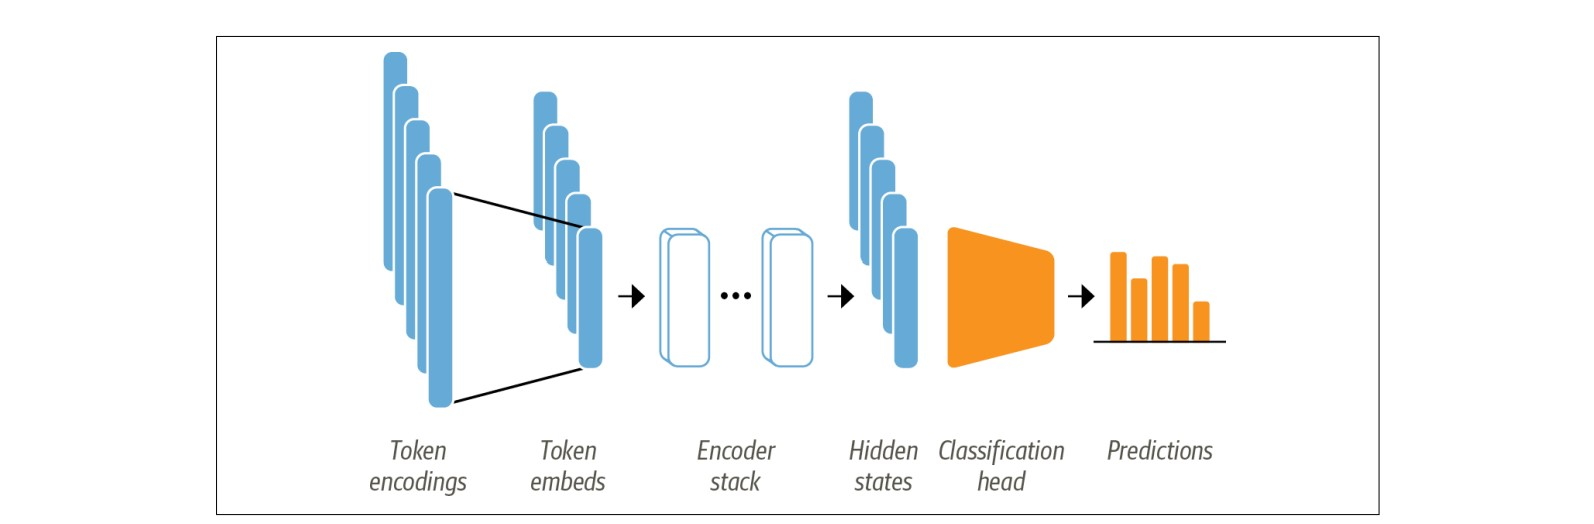

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

#### Evaluator

https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [16]:
# Build compute metrics function

accuracy = evaluate.load("accuracy")    # evaluate is a module from huggingface for computing metrics

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return accuracy.compute(predictions=predictions, references=labels)

In [17]:
# Arguments for training the model:

batch_size = 32     # is number of samples processed before the model is updated
training_dir = "train_dir"      # directory to save the model trainer directory means in the current directory

training_args = TrainingArguments(              # TrainingArguments is a class from huggingface
                                  output_dir=training_dir,      # save checkpoint in this directory
                                  overwrite_output_dir = True,      # overwrite the content of the output directory
                                  num_train_epochs = 2,     # epochs means the number of times the model will be trained with the dataset
                                  learning_rate = 2e-5,     # determines how large the steps the model takes to update its weights
                                  per_device_train_batch_size = batch_size,     # number of samples processed before the model is updated
                                  per_device_eval_batch_size = batch_size,      # number of samples processed before the model is updated
                                  weight_decay = 0.01,   # weight decay is a regularization technique
                                  evaluation_strategy = 'epoch'     # determines when to evaluate the model
)

In [18]:
trainer = Trainer(      # Trainer is a class from huggingface
    model=model,        # model to be trained
    compute_metrics=compute_metrics_evaluate,    # function to compute metrics
    train_dataset=encoded_dataset['train'],      # use the training dataset, use key 'train' to access the dataset
    eval_dataset=encoded_dataset['validation'],     # use for validation and adjusting hyperparameters and prevent overfitting
    tokenizer=distilbert_tokenizer
)

In [19]:
trainer.train()

Step,Training Loss
500,0.232800
1000,0.180400
1500,0.150700
2000,0.079000
2500,0.105500
3000,0.069100
3500,0.040000
4000,0.026000
4500,0.024000


TrainOutput(global_step=4800, training_loss=0.09636751333872477, metrics={'train_runtime': 13323.6425, 'train_samples_per_second': 2.881, 'train_steps_per_second': 0.36, 'total_flos': 903807467703504.0, 'train_loss': 0.09636751333872477, 'epoch': 3.0})

## Model Evaluation

In [21]:
preds_output = trainer.predict(     # predict method is used to predict the output of the model
    encoded_dataset['test']     # use the test dataset to evaluate the model
)

In [22]:
preds_output.metrics

{'test_loss': 0.19800488650798798,
 'test_accuracy': 0.9617067833698031,
 'test_runtime': 283.439,
 'test_samples_per_second': 12.899,
 'test_steps_per_second': 1.612}

In [28]:
# y_pred is output of the model
y_pred = np.argmax(     # np.argmax is used to get the index of the maximum value(means the predicted class)
    preds_output.predictions,   # predictions are the output of the model
    axis=1
)
y_true = encoded_dataset['test'][:]['label']

In [29]:
print(
    classification_report(
        y_true, 
        y_pred, 
        target_names=list(label2id)     # transform the dict keys into a list (["Real", "Fake"]), to use these names in the report (display under in graph Real(0.97 ...) and Fake(0.95 ...) 
    )
)

              precision    recall  f1-score   support

        Real       0.97      0.97      0.97      2072
        Fake       0.96      0.96      0.96      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## Benchmarking
Under is for evaluat the all Bert models performance

In [30]:
# # use sklearn to build compute metrics
# 
# 
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
# 
#     f1 = f1_score(labels, preds, average="weighted")
#     acc = accuracy_score(labels, preds)
# 
#     return {"accuracy": acc, "f1": f1}

In [31]:
# model_dict = {
#     "bert-base": "bert-base-uncased",
#     "distilbert": "distilbert-base-uncased",
#     "mobilebert": "google/mobilebert-uncased",
#     "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
# }
# 
# def train_model(model_name):
#     model_ckpt = model_dict[model_name]
#     tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
#     config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
#     model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)
# 
#     def local_tokenizer(batch):
#         temp = tokenizer(batch['title'], padding=True, truncation=True)
#         return temp
#     
#     encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)
# 
#     trainer = Trainer(
#                 model=model,
#                 compute_metrics=compute_metrics,
#                 train_dataset=encoded_dataset['train'],
#                 eval_dataset=encoded_dataset['validation'],
#                 tokenizer=tokenizer
#             )
#     
#     trainer.train()
# 
#     preds = trainer.predict(encoded_dataset['test'])
# 
#     return preds.metrics
#     
# 
# 
# model_performance = {}
# for model_name in model_dict:
#     print("\n\n")
#     print("Training Model: ", model_name)
# 
#     start = time.time()
#     result = train_model(model_name)
#     end = time.time()
#     
#     model_performance[model_name] = {model_name:result, "time taken": end-start}

In [32]:
# model_performance

In [33]:
#   'time taken': 679.7081322669983},
#   'time taken': 365.0743615627289},
#   'time taken': 902.2547216415405},
# 'time taken': 107.46117568016052



# Model Load and Save

In [34]:
trainer.save_model("fake_news")

In [35]:
classifier = pipeline('text-classification', model= 'fake_news')

In [53]:
classifier("some text data")

[{'label': 'Fake', 'score': 0.9997566342353821}]